In [ ]:
library(coxed)
library(dplyr)
library(zoo)

# Simulated Data Documentation

## Section 1: Simulated Survival Data

The simulated data represents observed deaths (in years) for 50,000 beneficiaries. In this simulation, **censoring** refers to a beneficiary's death within the observed period, and the event is recorded accordingly.

- **Age Distribution**: Age is generated according to the proportion from the Medicare Chartpack (see: [KFF Chartpack](https://files.kff.org/attachment/chartpack-profile-of-medicare-beneficiaries-by-race-and-ethnicity-a-chartpack)).
  
- **Date Simulation**: Dates are randomly assigned within the observation period defined in the paper. 
  
- **Survival Data Generation**: Survival data is simulated using the `sim.survdata()` function in R, which creates survival times.

Finally, individual characteristics are merged with the survival data to produce the final simulated survival dataset.

---

## Section 2: Simulated Person-Level Data (unused)

To generate variables such as medical cost and hospitalization rates, we assume the data follows a **log-normal distribution**, using the mean and standard deviation values provided in the original paper.

- **Why Log-Normal Distribution**: Log-normal distribution is suitable for expenditure data (e.g., medical costs), as it typically exhibits non-negative, right-skewed properties. This distribution captures the long-tail nature of spending data while ensuring all values remain positive. Moreover, the mean and standard deviation from the paper are directly applied in estimating the distribution parameters.

- **County and Date Assignment**: Randomly generated `county_fips` and `date` variables are merged with the expenditure and hospitalization data to form the simulated person-level dataset.

---

## Section 3: Simulated County-Level Data

Similarly to the person-level data, we generate county-level statistics for different age groups using a **log-normal distribution** to simulate mortality rates (measured as three-day deaths per million people) for each age category.

- **County and Date Assignment**: County-level variables, including `county_fips` and `date`, are also randomly generated and combined with the mortality data to create the final simulated county-level dataset.

---




### Section 1: Simulated Survival Data

In [125]:
set.seed(18)
N <- 50000

sex <- sample(c(1, 2), size = N, replace = T, prob = c(0.5, 0.5))

age_ranges <- list(
  "65_74"  = c(65, 74),
  "75_84"  = c(75, 84),
  "85_100" = c(85, 100)
)
age_proportions <- c(0.47, 0.39, 0.14)

# A function to generate age
generate_age <- function(n) {
  age_group <- sample(names(age_ranges), size = n, replace = TRUE, prob = age_proportions)
  ages <- sapply(age_group, function(group) {
    range <- age_ranges[[group]]
    sample(seq(range[1], range[2]), 1)
  })
  return(ages)
}

age <- generate_age(N)

X <- model.matrix(~ sex + age)[,-1]

In [127]:
set.seed(18)

# generate date
date_seq <- seq.Date(from = as.Date("1999-01-01"), to = as.Date("2013-12-31"), by = "day")
random_dates <- sample(date_seq, 50000, replace = TRUE)

formatted_dates <- format(random_dates, "%d%b%Y")

In [108]:
set.seed(18)
simdata <- sim.survdata(N=50000, T=15)
head(simdata$data)

,X1,X2,X3,y,failed
,<dbl>,<dbl>,<dbl>,<int>,<lgl>
1,-0.6511109,0.18957668,-0.433474723,1,FALSE
2,0.5542456,-0.85994691,-0.390969889,11,TRUE
3,-0.3860684,0.32240384,-0.004033863,12,FALSE
4,-0.3385851,0.07285019,-0.257748541,1,TRUE
5,0.2321536,0.62101825,-0.093331085,6,TRUE
6,-0.9751594,0.24620931,0.144139996,14,TRUE


TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]

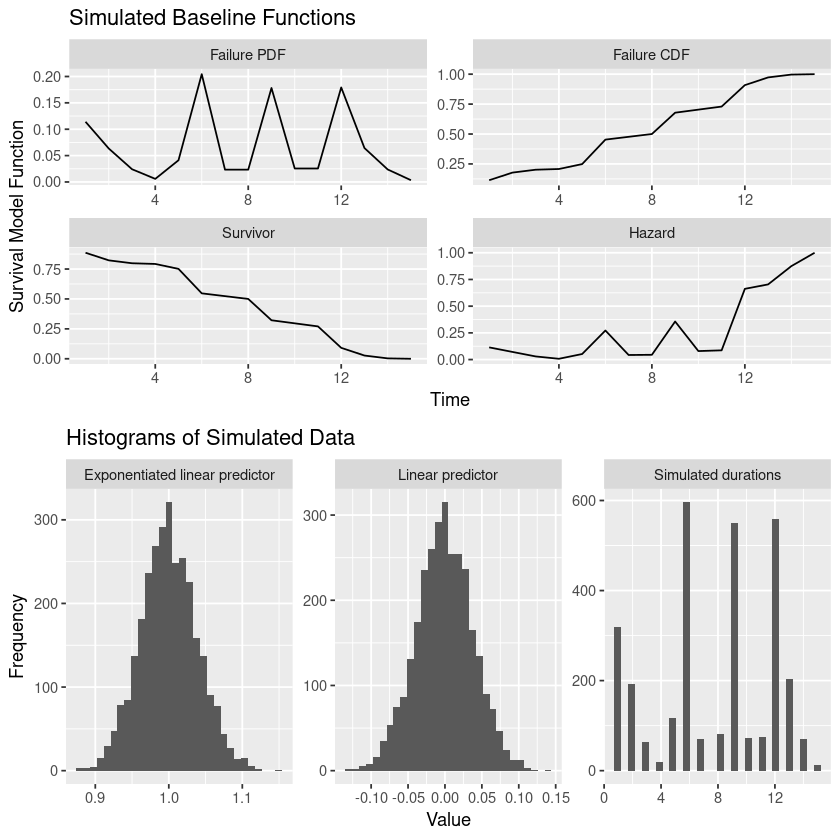

In [5]:
survsim.plot(simdata, df=1, type="both")

In [122]:
# gen survival data

#randomly generate county_fips
unique_counties <- read.csv("unique_county_fip.csv")
random_county_fips <- sample(unique_counties$county_list, 50000, replace = TRUE)
# merge the data
survival_simulate_data <- data.frame(
  county_fips = random_county_fips,
  Age = age,
  Sex = sex,
  Date = formatted_dates,
  mbsf_year = substr(formatted_dates, nchar(formatted_dates) - 3, nchar(formatted_dates)),
  time_to_event = simdata$data$y,
  event = simdata$data$failed, #event happen:true ; censor:false
  ffs2yr = 1
)

head(survival_simulate_data)

,county_fips,Age,Sex,Date,mbsf_year,time_to_event,event,ffs2yr
,<int>,<int>,<dbl>,<chr>,<chr>,<int>,<lgl>,<dbl>
1,18035,75,1,30Jan2012,2012,1,FALSE,1
2,49019,80,1,07Feb2013,2013,11,TRUE,1
3,51139,76,1,16Aug2008,2008,12,FALSE,1
4,39081,82,2,14Jun2012,2012,1,TRUE,1
5,27115,80,2,17Apr2001,2001,6,TRUE,1
6,23029,87,1,11Nov2000,2000,14,TRUE,1


### Section 2: Simulated Person-Level Data

In [6]:
set.seed(18)

# set parameters
n_counties <- 1302  # the number of counties given by the paper
mean_population <- 26901
sd_population <- 39335

# generate the population of each county
meanlog <- log((mean_population^2) / sqrt(sd_population^2 + mean_population^2))
sdlog <- sqrt(log(1 + (sd_population^2) / (mean_population^2)))
county_population <- rlnorm(n_counties, meanlog = meanlog, sdlog = sdlog)
# generate the 3days county data
mean_spending_3day <- 34598644
sd_spending_3day <- 15236367
mean_er_spending_3day <- 13793534
sd_er_spending_3day <- 7831989
mean_admission_rate_3day <- 3270
sd_admission_rate_3day <- 1207
mean_er_admission_rate_3day <- 1547
sd_er_admission_rate_3day <- 707
mean_er_visit_rate_3day <- 4185
sd_er_visit_rate_3day <- 1206

# calculate the parameters used in the log-normal
mu_log_spending <- log(mean_spending_3day^2 / sqrt(sd_spending_3day^2 + mean_spending_3day^2))
sigma_log_spending <- sqrt(log(1 + (sd_spending_3day^2 / mean_spending_3day^2)))
# use log-normal to generate the data
county_spending_3day <- rlnorm(n_counties, meanlog = mu_log_spending, sdlog = sigma_log_spending)

#*********
# 3 days ER spending data
mu_log_er_spending <- log(mean_er_spending_3day^2 / sqrt(sd_er_spending_3day^2 + mean_er_spending_3day^2))
sigma_log_er_spending <- sqrt(log(1 + (sd_er_spending_3day^2 / mean_er_spending_3day^2)))
county_er_spending_3day <- rlnorm(n_counties, meanlog = mu_log_er_spending, sdlog = sigma_log_er_spending)

#*********
# turn to the probility on person
county_admission_prob <- pmax(rnorm(n_counties, mean = mean_admission_rate_3day, sd = sd_admission_rate_3day) / 1e6, 0)
county_er_admission_prob <- pmax(rnorm(n_counties, mean = mean_er_admission_rate_3day, sd = sd_er_admission_rate_3day) / 1e6, 0)
county_er_visit_prob <- pmax(rnorm(n_counties, mean = mean_er_visit_rate_3day, sd = sd_er_visit_rate_3day) / 1e6, 0)
# ensure visit_prob and admission_prob is larger than er_admission_prob
min_required_admission_prob <- county_er_admission_prob + 1e-6
min_required_visit_prob <- county_er_admission_prob + 1e-6

county_admission_prob <- ifelse(county_admission_prob < min_required_admission_prob, 
                                 min_required_admission_prob, 
                                 county_admission_prob)

county_er_visit_prob <- ifelse(county_er_visit_prob < min_required_visit_prob, 
                                min_required_visit_prob, 
                                county_er_visit_prob)
# Assign to individual level:1 for hospitalization, 0 for non-hospitalization
# Person ER admission
person_er_admission_event <- unlist(lapply(1:n_counties, function(i) {
  rbinom(county_population[i], size = 1, prob = county_er_admission_prob[i] / 3)  # 每日的概率
}))

# Person admission
person_admission_event <- unlist(lapply(1:n_counties, function(i) {
  sapply(1:county_population[i], function(j) {
    if (person_er_admission_event[j] == 1) {
      1  # 该个体急诊入院，入院事件为1
    } else {
      rbinom(1, size = 1, prob = (county_admission_prob[i] - county_er_admission_prob[i]) / 3)
    }
  })
}))


# Person ER visit
person_er_visit_event <- unlist(lapply(1:n_counties, function(i) {
  sapply(1:county_population[i], function(j) {
    if (person_er_admission_event[j] == 1) {
      1  # 该个体急诊入院，急诊就诊事件为1
    } else {
      rbinom(1, size = 1, prob = (county_er_visit_prob[i] - county_er_admission_prob[i]) / 3)
    }
  })
}))

# use the county population to calculate the person-day data
county_spending_1day <- county_spending_3day / 3
county_er_spending_1day <- county_er_spending_3day / 3

person_spending_1day <- unlist(lapply(1:n_counties, function(i) {
  rep(county_spending_1day[i] / county_population[i], county_population[i])
}))

person_er_spending_1day <- unlist(lapply(1:n_counties, function(i) {
  rep(county_er_spending_1day[i] / county_population[i], county_population[i])
}))

# check the results
summary(person_spending_1day)
summary(person_er_spending_1day)
table(person_admission_event)
table(person_er_admission_event)
table(person_er_visit_event)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   22.33   112.24   236.70   445.11   491.28 42108.27 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   7.099   41.803   87.294  172.033  179.827 9922.863 

person_admission_event
       0        1 
33680500    28508 

person_er_admission_event
       0        1 
33691490    17518 

person_er_visit_event
       0        1 
33671286    37722 

In [26]:
set.seed(18)  

#ransomly generate county_fips
unique_counties <- read.csv("unique_county_fip.csv")
random_county_fips <- sample(unique_counties$county_list, 3000, replace = TRUE)

sample_person_spending <- sample(person_spending_1day, 3000, replace = TRUE)
sample_person_er_spending <- sample(person_er_spending_1day, 3000, replace = TRUE)
sample_person_admission <- sample(person_admission_event, 3000, replace = TRUE)
sample_person_er_admission <- sample(person_er_admission_event, 3000, replace = TRUE)
sample_person_er_visit <- sample(person_er_visit_event, 3000, replace = TRUE)

person_simulate_data <- data.frame(
  county_fips = random_county_fips,
  Age = age,
  Sex = sex,
  Date = formatted_dates,
  totamt_any = sample_person_spending, # inpatient spending, planned and ER
  totamt_er = sample_person_er_spending, # inpatient ER spending
  admission_event = sample_person_admission,
  ER_admission_event = sample_person_er_admission,
  ER_visit_event = sample_person_er_visit,
  time_to_event = simdata$data$y,
  event = simdata$data$failed #event happen:true ; censor:false,4
)

head(person_simulate_data)

,county_fips,Age,Sex,Date,totamt_any,totamt_er,admission_event,ER_admission_event,ER_visit_event,time_to_event,event
,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<lgl>
1,32033,69,1,30Jan2012,243.3579,84.823296,0,0,0,1,FALSE
2,47107,71,1,07Feb2013,778.5528,365.933906,0,0,0,10,TRUE
3,37173,81,1,16Aug2008,1165.9524,210.668511,0,0,0,9,TRUE
4,38105,73,2,14Jun2012,571.7920,13.128478,0,0,0,1,TRUE
5,32031,84,2,17Apr2001,278.9991,109.059459,0,0,0,5,FALSE
6,51197,68,1,11Nov2000,108.0365,9.560399,0,0,0,5,TRUE



   0    1 
2998    2 

### Section 3: Simulated County-Level Data

In [106]:
set.seed(18)

random_county_fips2 <- sample(unique_county_fips, 50000, replace = TRUE)
random_dates2 <- sample(date_seq, 50000, replace = TRUE)
formatted_dates2 <- format(random_dates2, "%d%b%Y")
# set parameters
n_ct_obsevations <- 50000  
mean_population <- 26901
sd_population <- 39335

meanlog <- log((mean_population^2) / sqrt(sd_population^2 + mean_population^2))
sdlog <- sqrt(log(1 + (sd_population^2) / (mean_population^2)))
county_population <- rlnorm(n_ct_obsevations, meanlog = meanlog, sdlog = sdlog)

# generate the data (meanlog and sdlog has calculated in the previous part)
county_spending_3day <- rlnorm(n_ct_obsevations, meanlog = mu_log_spending, sdlog = sigma_log_spending)
county_er_spending_3day <- rlnorm(n_ct_obsevations, meanlog = mu_log_er_spending, sdlog = sigma_log_er_spending)

#********
# genrate mortality（three-day deaths per million people）
mortality_rate_means <- c(388.25, 135.37, 201.83, 320.70, 526.38, 1168.68)
mortality_rate_sds <- c(247.60, 264.38, 369.19, 487.38, 787.33, 1118.87)
age_groups <- c("100", "65", "70", "75", "80", "85")

simulate_data <- data.frame(matrix(nrow = n_ct_obsevations, ncol = length(age_groups)))
colnames(simulate_data) <- paste0("mort_3day_", age_groups)

# generate mortality for each age group
for (i in 1:length(age_groups)) {
  mu_log <- log((mortality_rate_means[i]^2) / sqrt(mortality_rate_sds[i]^2 + mortality_rate_means[i]^2))
  sigma_log <- sqrt(log(1 + (mortality_rate_sds[i]^2) / mortality_rate_means[i]^2))
  
  simulated_rates <- rlnorm(n_ct_obsevations, meanlog = mu_log, sdlog = sigma_log)

  simulate_data[, i] <- simulated_rates
}
#********
#beneficiary number
beneficiary_means <- c(49106, 13173, 11672, 9658, 7452, 7151, 34196)
beneficiary_sds <- c(78983, 20910, 18802, 15767, 12183, 11818, 52812)
beneficiary_vars <- c("numbenes3_100", "numbenes3_65", "numbenes3_70", "numbenes3_75", "numbenes3_80", "numbenes3_85", "hosp_denom")

for (i in 1:length(beneficiary_vars)) {
  mu_log <- log((beneficiary_means[i]^2) / sqrt(beneficiary_sds[i]^2 + beneficiary_means[i]^2))
  sigma_log <- sqrt(log(1 + (beneficiary_sds[i]^2) / beneficiary_means[i]^2))
  simulate_data[[beneficiary_vars[i]]] <- rlnorm(n_ct_obsevations, meanlog = mu_log, sdlog = sigma_log)
}

#************
# merge the data
county_simulate_data <- data.frame(
  county_fips = random_county_fips2,
  Date = formatted_dates2,
  totamt_any_3day = county_spending_3day, #Three-day inpatient spending, planned and ER
  totamt_er_3day = county_er_spending_3day, # inpatient ER spending
  admit_any_3day = county_admission_prob,
  admit_er_3day = county_er_admission_prob,
  all_er_3day = county_er_visit_prob
)
county_simulate_data <- cbind(county_simulate_data, simulate_data)
head(county_simulate_data)

,county_fips,Date,totamt_any_3day,totamt_er_3day,admit_any_3day,admit_er_3day,all_er_3day,mort_3day_100,mort_3day_65,mort_3day_70,mort_3day_75,mort_3day_80,mort_3day_85,numbenes3_100,numbenes3_65,numbenes3_70,numbenes3_75,numbenes3_80,numbenes3_85,hosp_denom
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,32033,06Nov2002,26155246,20754543,6428.016,1343.8068,5707.709,308.1248,278.563437,256.18880,42.94745,1113.26059,1246.2658,104033.13,160543.968,13397.5713,2131.352,1931.107,2525.066,4000.528
2,47107,09Dec2010,21671254,24063484,2081.956,2023.6680,5038.477,501.9261,113.173343,22.49953,37.40322,57.19656,733.8271,43837.66,8478.319,2096.6593,3687.162,6226.843,2118.190,10250.305
3,37173,31Dec2004,42591606,15307722,6720.976,742.6134,4633.614,248.1606,6.311832,28.34911,159.61417,169.97788,951.0129,287910.70,5518.611,11800.7052,6918.435,1724.187,6794.942,51702.394
4,38105,25Dec2012,22650498,17140481,2013.597,962.8970,2840.197,169.2352,37.415654,108.39215,2173.03029,205.18090,458.9444,79037.96,11694.212,2357.1932,17821.541,3400.070,2136.881,18272.317
5,32031,26Apr1999,45396774,8559522,3000.296,1815.7436,4481.831,134.1252,19.302115,14.24617,238.33694,371.40945,293.5613,21292.60,48168.629,2497.9533,2173.179,1629.583,8327.971,81800.618
6,51197,11Nov2005,25747679,29485772,2460.315,0.0000,3542.584,128.3938,64.971260,50.13332,62.95865,813.12780,884.8010,20615.05,26050.722,160.3363,12297.640,10286.112,1536.519,26944.941


In [69]:
write.csv(survival_simulate_data, "survival_simulate_data.csv", row.names = FALSE)
write.csv(person_simulate_data, "person_simulate_data.csv", row.names = FALSE)
write.csv(county_simulate_data, "county_simulate_data.csv", row.names = FALSE)